Modeling
---

We are attempting to predict a continuous variable. I will try the following models:

1. Lasso Linear Regression
2. Gradient Boosted Lasso
3. Random Forest

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model, preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import ttest_ind, logistic, uniform, randint

import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool

import warnings
warnings.filterwarnings('ignore')

We made train/test splits in the previous step, but for the life of me I can't figure out why.

Let's just get all our data in here, then run cross validation on all of them with new splits.

In [2]:
total_set = pd.read_json('../data/Step 3 - Total Set.json', orient='records')

train_set = total_set[total_set['set']=='train']

X_master = train_set.drop(['set', 'SalePrice'], axis=1)

y = train_set['SalePrice']

test_set = total_set[total_set['set'] == 'test']

Doing some last-minute feature selection.

In [3]:
all_X_cols = X_master.columns

In [4]:
%store -r usable_cats

hot_cats = []

for cat in usable_cats :
    for col in all_X_cols :
        if cat in col :
            hot_cats.append(col)


In [5]:
best_numerics = ['OverallQual',
 'GrLivArea',
 'ExterQual',
 'KitchenQual',
 'BsmtQual',
 'GarageArea',
 'TotalBsmtSF',
 'FullBath',
 'YearBuilt',
 'GarageFinish',
 'YearRemodAdd']

In [6]:
usable_cols = []

usable_cols.extend(hot_cats)
usable_cols.extend(best_numerics)

In [7]:
X = X_master[usable_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Lasso
---

For comparison, I'll grid search for optimal alpha and then compare to the result of Bayesian optimization.

In [8]:
# Finding optimal alpha by randomized search.

model = Lasso(max_iter=100000)

param_ranges = {
    "alpha" : np.logspace(-30, 2, num=1000, base=10)
}

gscv_lasso = RandomizedSearchCV(model, param_ranges, scoring='r2', cv=5, n_jobs=-1)

gscv_lasso.fit(X, y)

rscv_alpha = gscv_lasso.best_params_['alpha']

# best_alpha
gscv_lasso.best_params_

{'alpha': 1.3186214013947485e-06}

In [9]:
# Finding optimal alpha by Bayesian optimization.

param_bounds = {"alpha":(0, 100)}

def Lasso_eval(alpha) :
    params = {"alpha":alpha}

    model = Lasso(max_iter=100000, **params)

    score = cross_val_score(model, X, y, cv=5).mean()

    return score

optimal = BayesianOptimization(Lasso_eval, param_bounds, verbose=False, allow_duplicate_points=True)

optimal.maximize(60, 60)

print(optimal.max)

bayes_alpha = optimal.max['params']['alpha']

{'target': 0.8622467409104987, 'params': {'alpha': 53.49013168286988}}


Interesting discrepancy.

Now I'll get 30 R2 scores for this model to help create a generalized comparison between all my models.

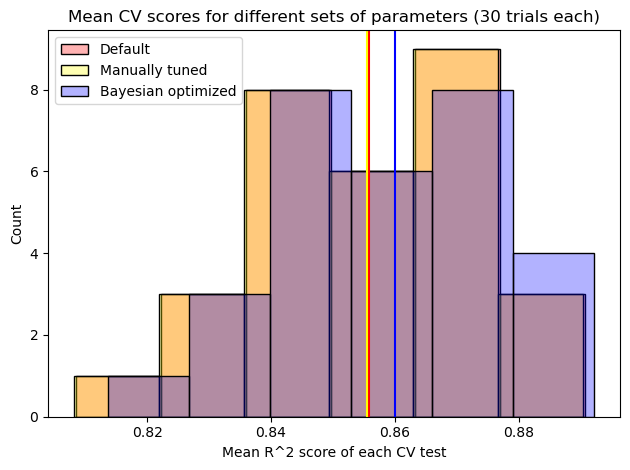

In [10]:
default = []
tuned = []
bayesian = []

for i in range(30) :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = Lasso()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    default.append(r2_score(y_test, y_pred))

    model = Lasso(max_iter=10000, alpha=rscv_alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tuned.append(r2_score(y_test, y_pred))

    model = Lasso(max_iter=10000, alpha=bayes_alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    bayesian.append(r2_score(y_test, y_pred))

default_lasso = np.array(default)
tuned_lasso = np.array(tuned)
bayesian_lasso = np.array(bayesian)

sns.histplot(default_lasso, alpha=0.3, color='red', bins='auto', common_norm=True, label='Default')
sns.histplot(tuned_lasso, alpha=0.3, color='yellow', bins='auto', common_norm=True, label='Manually tuned')
sns.histplot(bayesian_lasso, alpha=0.3, color='blue', bins='auto', common_norm=True, label='Bayesian optimized')
plt.axvline(x=default_lasso.mean(), color='red')
plt.axvline(x=tuned_lasso.mean(), color='yellow')
plt.axvline(x=bayesian_lasso.mean(), color='blue')
plt.legend()
plt.title('Mean CV scores for different sets of parameters (30 trials each)')
plt.xlabel('Mean R^2 score of each CV test')
plt.tight_layout()
plt.show()

It appears that 1 is indeed the default value of alpha, so the manually tuned and default versions are identical.

It's interesting that shifting the parameters improved performance uniformly, preserving the shape of irregular distribution.

Gradient Boosted
---

Let's tune some parameters with Bayesian optimization, then compare to the default settings to see how much the tuning improves performance.

In [11]:
param_bounds = param_ranges = {
    'n_estimators': (50, 300),
    'learning_rate': (0.01, 1),
    'max_depth': (2, 30),
    'min_samples_split': (2, 60),
    'min_samples_leaf': (1, 5),
    'subsample': (0.1, 1),
}

def GB_eval(n_estimators, learning_rate, max_depth, min_samples_split, \
            min_samples_leaf, subsample) :
    params = {
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'subsample': subsample
    }

    model = GradientBoostingRegressor(**params)
    score = cross_val_score(model, X, y, cv=5).mean()

    return score

optimal = BayesianOptimization(GB_eval, param_bounds, verbose=False)
optimal.maximize(60, 100)
print(optimal.max)

bayes_gb_params = {}
float_parameters = ['learning_rate', 'subsample']

for key, value in optimal.max['params'].items() :
    if key in float_parameters :
        bayes_gb_params[key] = value
    else:
        bayes_gb_params[key] = int(round(value, 0))

bayes_gb_params

{'target': 0.8855213051628702, 'params': {'learning_rate': 0.11466078879019266, 'max_depth': 3.252701036209882, 'min_samples_leaf': 4.929666859645639, 'min_samples_split': 12.031469710671438, 'n_estimators': 215.028071514741, 'subsample': 0.7296788949067566}}


{'learning_rate': 0.11466078879019266,
 'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 215,
 'subsample': 0.7296788949067566}

Now let's compare our performances.

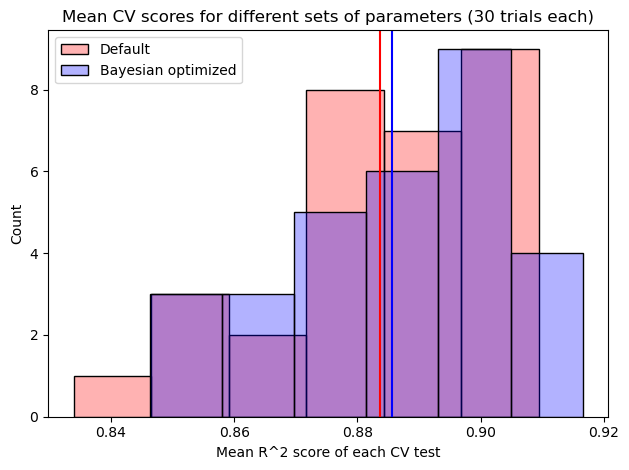

In [12]:
default = []
bayesian = []

for i in range(30) :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model_default = GradientBoostingRegressor()
    model_default.fit(X_train, y_train)
    y_pred = model_default.predict(X_test)
    default.append(r2_score(y_test, y_pred))

    model_bayes = GradientBoostingRegressor(**bayes_gb_params)
    model_bayes.fit(X_train, y_train)
    y_pred = model_bayes.predict(X_test)
    bayesian.append(r2_score(y_test, y_pred))

default_gb = np.array(default)
bayesian_gb = np.array(bayesian)


sns.histplot(default_gb, alpha=0.3, color='red', bins='auto', common_norm=True, label='Default')
sns.histplot(bayesian_gb, alpha=0.3, color='blue', bins='auto', common_norm=True, label='Bayesian optimized')
plt.axvline(x=default_gb.mean(), color='red')
plt.axvline(x=bayesian_gb.mean(), color='blue')
plt.legend()
plt.title('Mean CV scores for different sets of parameters (30 trials each)')
plt.xlabel('Mean R^2 score of each CV test')
plt.tight_layout()
plt.show()

The parameter tuning does seem to help, but not as much as I'd hoped.

The long left tail suggests to me that there might be some weirdness left in the data that messes up the model when it interfaces with the train/test split in specific ways. If those low scores are the result of the same splits, that would strengthen my hypothesis.

Let's find the index of the low scores in one set and see if they match up with the low scores in the other set.

In [13]:
bad_day = np.where(default_gb < 0.86)

print(default_gb[bad_day])
print(bayesian_gb[bad_day])

[0.85478327 0.833961   0.85678076 0.8542801 ]
[0.85728199 0.84629102 0.85145345 0.85832017]


All of these scores are well below the means. This does suggest that something about the data in different splits causes the entire model to become less accurate regardless of the parameters. Finding this quality in the data and mitigating it might improve performance.

There may be a way to engineer my way out of that, but for now, let's continue.

Random Forest
---

Same as with Graident Boosting, let's test some Bayesian parameters against the default.

In [14]:
param_bounds = param_ranges = {
    'n_estimators': (50, 600),
    'max_depth': (2, 60),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 5),
    'max_features': (1, 70),
    'n_jobs': (-1, -1)
}

def RF_eval(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, n_jobs) :
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'max_features': int(max_features),
        'n_jobs': int(n_jobs)
    }

    model = RandomForestRegressor(**params)
    score = cross_val_score(model, X, y, cv=5).mean()

    return score

optimal = BayesianOptimization(RF_eval, param_bounds, verbose=False)
optimal.maximize(60, 100)
print(optimal.max)

bayes_rf_params = {}

for key, value in optimal.max['params'].items() :
    bayes_rf_params[key] = int(round(value, 0))

bayes_rf_params

{'target': 0.8772398716512487, 'params': {'max_depth': 25.391735923214732, 'max_features': 21.359971180523008, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 383.9129297761335, 'n_jobs': -1.0}}


{'max_depth': 25,
 'max_features': 21,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 384,
 'n_jobs': -1}

Now I'll get a set of 30 R2 scores from the default parameters, my manually-tuned parameters, and Bayesian optimized parameters for comparison.

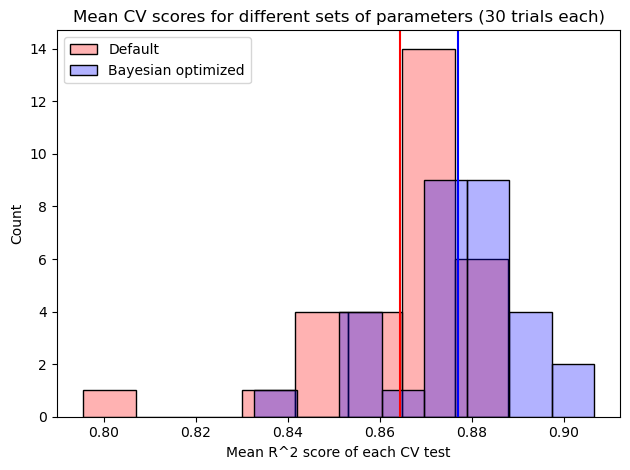

In [15]:
default = []
bayesian = []

for i in range(30) :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    default.append(r2_score(y_test, y_pred))

    model = RandomForestRegressor(**bayes_rf_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    bayesian.append(r2_score(y_test, y_pred))

default_rf = np.array(default)
bayesian_rf = np.array(bayesian)

sns.histplot(default_rf, alpha=0.3, color='red', bins='auto', label='Default')
sns.histplot(bayesian_rf, alpha=0.3, color='blue', bins='auto', label='Bayesian optimized')
plt.axvline(x=default_rf.mean(), color='red')
plt.axvline(x=bayesian_rf.mean(), color='blue')
plt.legend()
plt.title('Mean CV scores for different sets of parameters (30 trials each)')
plt.xlabel('Mean R^2 score of each CV test')
plt.tight_layout()
plt.show()

Conclusion
---

In [16]:
print(f'R2 score for Gradient Boost: {bayesian_gb.mean()}')
print(f'R2 score for Random Forest: {bayesian_rf.mean()}')


R2 score for Gradient Boost: 0.8855441842997067
R2 score for Random Forest: 0.8770697661424947


Gradient Boost seems slightly better, but is that just chance?

In [17]:
t_stat, p_value = ttest_ind(bayesian_gb, bayesian_rf)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: 1.939077258199279
P-value: 0.057361971605446586


We can't reject that null hypothesis. (And the last time I ran this notebook, Random Forest came out on top.)

Thus, as the data stands, the Graident Boost and Random Forest models are both good candidates.

To improve the model, we may have to do further work on our preprocessing and feature selection.